In [2]:
import numpy as np
import strax
import straxen
import wfsim

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from multihist import Histdd, Hist1d
from scipy import stats

import json

In [3]:
import os, sys
sys.path

['/dali/lgrandi/kazama/xenonnt/ml/wfsim',
 '/dali/lgrandi/strax/miniconda3/envs/strax/lib/python37.zip',
 '/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7',
 '/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/lib-dynload',
 '',
 '/home/kazama/.local/lib/python3.7/site-packages',
 '/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages',
 '/dali/lgrandi/strax/flamedisx',
 '/dali/lgrandi/strax/strax',
 '/dali/lgrandi/strax/straxen',
 '/dali/lgrandi/strax/WFSim',
 '/dali/lgrandi/strax/utilix',
 '/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/IPython/extensions',
 '/home/kazama/.ipython']

In [4]:
config = dict(detector='XENONnT',
                    **straxen.contexts.xnt_common_config,
                    to_pe_file= 'https://raw.githubusercontent.com/XENONnT/'
                                   'strax_auxiliary_files/master/fax_files/to_pe_nt.npy',
                    fax_config='https://raw.githubusercontent.com/XENONnT/'
                               'strax_auxiliary_files/master/fax_files/fax_config_nt.json',
                    
                    )
config.update(dict(gain_model=('to_pe_constant', 0.00612255) ))

In [5]:
st = strax.Context(
        storage=strax.DataDirectory('./strax_data'),
        register=wfsim.RawRecordsFromFax,
        config=config,
        timeout= 3600,
        **straxen.contexts.common_opts)

config = dict(nchunk=1, event_rate=1, chunk_size=200)#options.NUMEVENTS,)
st.set_config(config)
st.set_config(dict(fax_file=None))

In [6]:
run_id = '1'

In [7]:
## Neutron Energy Spectrum in keVnr 

def map_averaging(data, plot_end):
    bin_centers = map_binning(data)
    end_bin = np.digitize(plot_end, bin_centers)
    data['map'] = [np.average(data['map'][0:end_bin])]*len(data['map'])
    return data

def map_binning(data):
    bin_edges = np.linspace(0.0, np.float32(data['coordinate_system'][0][1][1]), data['coordinate_system'][0][1][2]+1)
    bin_centers = bin_edges[1:]-(bin_edges[1:]-bin_edges[:-1])/2.
    return bin_centers

with open('Radiogenics.json') as json_file:
    radiogenics_data_map = json.load(json_file)

In [8]:
## Normalize the spectrum using events in [4, 50] keVnr

scale = 1./np.sum(radiogenics_data_map['map'][40:500])
normalized_spectra = np.array(radiogenics_data_map['map'][40:500])*scale

In [9]:
## Get Neutron Recoil Energy

#from numpy.random import choice
#draw = choice(map_binning(radiogenics_data_map)[40:500], 10, p=np.array(normalized_spectra))
#draw

In [10]:
# drift velocity in LXe with [um/nsec] unit

v_dt = 1e4*straxen.get_resource('/home/kazama/dali/xenonnt/ml/wfsim/fax_config_1t.json',fmt='json')['drift_velocity_liquid']
v_dt

1.335

In [11]:
def instruction_for_double_S2s(c):

    import nestpy
    from numpy.random import choice

    n_mean_length = 10. # mean interaction length for neutrons: ~10cm
    
    c['total_time'] = c['chunk_size'] * c['nchunk'] # will not be used for anything
    n = 10 ## Number of events to be simulated, 
    #n = c['nevents'] = c['event_rate'] * c['chunk_size'] * c['nchunk']

    ## Number of simulated truth is 2*n for double scatter simulation
    instructions = np.zeros(2 * n, dtype=wfsim.instruction_dtype)
    
    ## event_number is [0, 0, 1, 1, ..., n, n] 
    instructions['event_number'] = np.asarray([(i+((-1)**i-1)/2)/2 for i in range(2*n)],
                                              dtype = int)
    print('generated event_number = ', instructions['event_number'])
    
    instructions['type'] = np.repeat([2], 2 * n) ## S2
    instructions['recoil'] = np.repeat(np.array(["nr"], dtype='<U2'), 2*n)
    instructions['x'] = np.repeat(0, 2 * n)
    instructions['y'] = np.repeat(0, 2 * n)

    z_val = []
    t_val = []
    
    ## first interaction is generated randomly in [-140, -10]cm at the moment
    z_min = -140
    z_max = -10
    
    for i in range(0, n):
        z_val1 = np.random.uniform(z_min, z_max, 1)
        z_val2 = 3 
        
        # if the distance between S2[0] and S2[1] is > 2mm, can reconstruct 2S2s
        #
        while z_val2 > 2:
            z_val2 = np.random.exponential(n_mean_length, 1)
        
        t_val1 = 0.
        t_val2 = z_val2*1e4/v_dt # nano-second
        
        z_val2 = z_val1 - z_val2    
        z_val.append(z_val1[0])
        z_val.append(z_val2[0])
        
        t_val.append(t_val1)
        t_val.append(int(t_val2[0]))
    
    z_val = np.array(z_val)
    t_val = np.array(t_val)
    
    t = np.zeros(2*n)

    for i in range(0, 2*n):
        if i%2 == 0:
            t[i] = 1e9*i/2. + 1e6
        if i%2 != 0:
            t[i] = t[i-1] + t_val[i]
        
    #instructions['z'] = np.repeat(np.random.uniform(-100, 0, n), 4)
    instructions['z'] = z_val

    #instructions['time'] = 1e9*np.arange(0,n, dtype= float) +1e6 # Andrii's code
    instructions['time'] = t

    # nestpy to get QY for NR for given energy
    nc = nestpy.NESTcalc(nestpy.VDetector())
    A = 131.293
    Z = 54.
    density = 2.862  # g/cm^3   #SR1 Value
    drift_field = 82  # V/cm    #SR1 Value
    interaction = nestpy.INTERACTION_TYPE(0) # NR
    
    energy_range = map_binning(radiogenics_data_map)[40:500] # [4, 50] keV region
    energy = choice(energy_range, 2 * n, p=np.array(normalized_spectra))

    quanta = []
    for en in energy:
        y = nc.GetYields(interaction,
                         en,
                         density,
                         drift_field,
                         A,
                         Z)
        quanta.append(nc.GetQuanta(y, density).electrons)
        
    instructions['amp'] = quanta
    print('generated # of e- = ', quanta)

    instructions = instructions[instructions["amp"] > 0]
    
    print('generatd S2 time = ', instructions['time'])
    
    return instructions

In [12]:
wfsim.strax_interface.rand_instructions = instruction_for_double_S2s
wfsim.rand_instructions = instruction_for_double_S2s

In [13]:
wfsim.instruction_dtype

[('event_number', numpy.int32),
 ('type', numpy.int8),
 ('time', numpy.int64),
 ('x', numpy.float32),
 ('y', numpy.float32),
 ('z', numpy.float32),
 ('amp', numpy.int32),
 ('recoil', '<U2')]

In [14]:
#wfsim.rand_instructions??

In [15]:
#st.set_config(dict(fax_file= '/dali/lgrandi/pgaemers/fax_files/Xenon1T_WholeLXe_Pb212_00008_g4mc_G4.root'))

In [16]:
straxen.get_resource('fax_config_1t.json',fmt='json').keys()

dict_keys(['anode_field_domination_distance', 'anode_voltage', 'anode_wire_radius', 'channels_bottom', 'channels_in_detector', 'detector', 'diffusion_constant_liquid', 'digitizer_bits', 'digitizer_reference_baseline', 'digitizer_voltage_range', 'drift_field', 'drift_time_gate', 'drift_velocity_liquid', 'electron_extraction_yield', 'electron_lifetime_liquid', 'electron_trapping_time', 'elr_gas_gap_length', 'external_amplification', 'gas_drift_velocity_slope', 'gate_to_anode_distance', 'gauss_noise_sigmas', 'led_pulse_length', 'liquid_density', 'lxe_dielectric_constant', 'maximum_recombination_time', 'p_double_pe_emision', 'pe_pulse_ts', 'pe_pulse_ys', 'photoelectric_modifier', 'photoelectric_p', 'photoelectric_t_center', 'photoelectric_t_spread', 'photoionization_modifier', 'pmt_ap_modifier', 'pmt_ap_t_modifier', 'pmt_circuit_load_resistor', 'pmt_pulse_time_rounding', 'pmt_transit_time_mean', 'pmt_transit_time_spread', 'pressure', 'real_noise_sample_mode', 'real_noise_sample_size', 'rig

In [17]:
truth = st.get_array(run_id, 'truth')

In [18]:
truth.dtype

dtype([('event_number', '<i4'), ('type', 'i1'), ('time', '<i8'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('amp', '<i4'), ('recoil', '<U2'), ('n_electron', '<f8'), ('n_photon', '<f8'), ('n_photon_bottom', '<f8'), ('t_first_photon', '<f8'), ('t_last_photon', '<f8'), ('t_mean_photon', '<f8'), ('t_sigma_photon', '<f8'), ('t_first_electron', '<f8'), ('t_last_electron', '<f8'), ('t_mean_electron', '<f8'), ('t_sigma_electron', '<f8'), ('endtime', '<i8')])

In [19]:
truth=truth[truth['type']==2]
truth['time']

array([   1768015,    1769768, 1001455080, 1001481121, 2001144708,
       2001158960, 3001722283, 3001725752, 4001086904, 4001105646,
       5001119312, 5001132717, 6001957743, 6001975654, 7001633022,
       7001656877, 8001186257, 8001188879])

In [20]:
def abs_time_and_samples(p):

    n = p['length']
    x = ((p['time']) + np.arange(n + 1) * p['dt']) / int(1e9)
    #x = ((p['time']) + np.arange(n + 1) * p['dt']) 

    y = p['data'][:n] / p['dt']
    return x, np.concatenate([[y[0]], y])


def plot_get_peak_with_abs_t(p, **kwargs):
    x, y = abs_time_and_samples(p)
    kwargs.setdefault('linewidth', 1)

    # Plot waveform
    plt.plot(x, y,
             drawstyle='steps-pre',
             **kwargs)
    if 'linewidth' in kwargs:
        del kwargs['linewidth']
    kwargs['alpha'] = kwargs.get('alpha', 1) * 0.2
    plt.fill_between(x, 0, y, step='pre', linewidth=0, **kwargs)

    # Mark extent with thin black line
    plt.plot([x[0], x[-1]], [y.max(), y.max()],
             c='k', alpha=0.3, linewidth=1)
    
    plt.ylabel('PE/sample')
    plt.xlabel('time [sec]')
    return x, y

In [21]:
def time_and_samples(p, t0=None):
    """Return (x, y) numpy arrays for plotting the waveform data in p
    using 'steps-pre'.
    Where x is the time since t0 in seconds (or another time_scale),
      and y is intensity in PE / ns.
    :param p: Peak or other similar strax data type
    :param t0: Zero of time in ns since unix epoch
    """
    n = p['length']
    if t0 is None:
        t0 = p['time']
    #x = ((p['time'] - t0) + np.arange(n + 1) * p['dt']) / int(1e9)
    x = ((p['time'] - t0) + np.arange(n + 1) * p['dt']) 

    y = p['data'][:n] / p['dt']
    return x, np.concatenate([[y[0]], y])


def plot_get_peak(p, t0=None, **kwargs):
    x, y = time_and_samples(p, t0=t0)
    kwargs.setdefault('linewidth', 1)

    # Plot waveform
    plt.plot(x, y,
             drawstyle='steps-pre',
             **kwargs)
    if 'linewidth' in kwargs:
        del kwargs['linewidth']
    kwargs['alpha'] = kwargs.get('alpha', 1) * 0.2
    plt.fill_between(x, 0, y, step='pre', linewidth=0, **kwargs)

    # Mark extent with thin black line
    plt.plot([x[0], x[-1]], [y.max(), y.max()],
             c='k', alpha=0.3, linewidth=1)
    plt.ylabel('PE/sample')
    plt.xlabel('time [nsec]')   
#    return x, y

In [22]:
## To show PMT hit-pattern

%run s1_utils.py

In [23]:
peaks = st.get_array(run_id, ['peaks'])

In [24]:
peaks.dtype

dtype([(('Start time since unix epoch [ns]', 'time'), '<i8'), (('Length of the interval in samples', 'length'), '<i4'), (('Width of one sample [ns]', 'dt'), '<i2'), (('Channel/PMT number', 'channel'), '<i2'), (('Classification of the peak(let)', 'type'), 'i1'), (('Integral across channels [PE]', 'area'), '<f4'), (('Integral per channel [PE]', 'area_per_channel'), '<f4', (494,)), (('Number of hits contributing at least one sample to the peak ', 'n_hits'), '<i4'), (('Waveform data in PE/sample (not PE/ns!)', 'data'), '<f4', (200,)), (('Peak widths in range of central area fraction [ns]', 'width'), '<f4', (11,)), (('Peak widths: time between nth and 5th area decile [ns]', 'area_decile_from_midpoint'), '<f4', (11,)), (('Does the channel reach ADC saturation?', 'saturated_channel'), 'i1', (494,)), (('Total number of saturated channels', 'n_saturated_channels'), '<i2'), (('Hits within tight range of mean', 'tight_coincidence'), '<i2'), (('Largest gap between hits inside peak [ns]', 'max_gap'

In [25]:
peaks['time']

array([   1768000, 1001455060, 1001481100, 2001145650, 2001154770,
       3001722270, 4001086900, 4001105630, 5001119290, 5001132700,
       6001957730, 6001975640, 7001633000, 7001656860, 8001186240])

In [26]:
peaks['length']

array([165, 192, 195, 188, 171, 182, 193, 168, 144, 140, 165, 186, 158,
       157, 169], dtype=int32)

In [27]:
peaks['dt']

array([50, 30, 30, 20, 50, 60, 20, 30, 30, 30, 40, 40, 30, 40, 40],
      dtype=int16)

In [28]:
peaks['dt']*peaks['length']

array([ 8250,  5760,  5850,  3760,  8550, 10920,  3860,  5040,  4320,
        4200,  6600,  7440,  4740,  6280,  6760], dtype=int32)

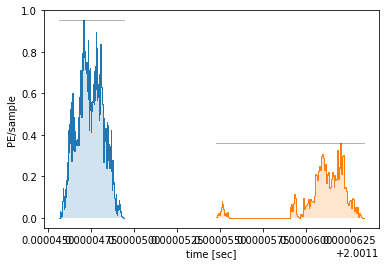

In [29]:
for i in range(3, 5):

    plot_get_peak_with_abs_t(peaks[i])

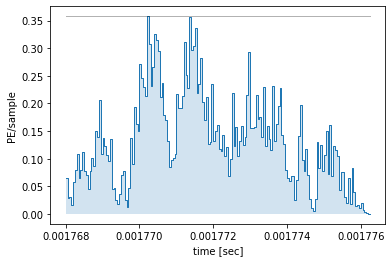

In [30]:
for i in range(0, 1):

    plot_get_peak_with_abs_t(peaks[i])

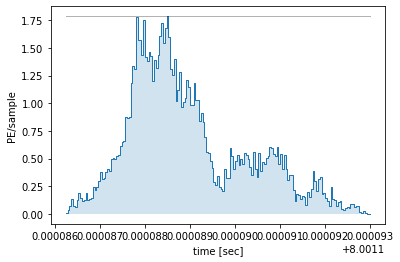

In [54]:
for i in range(14, 15):

    plot_get_peak_with_abs_t(peaks[i])

In [37]:
true_S2s = truth[truth['type']==2]

n_events = int(len(true_S2s)/2.)

dtype = [    
             ('is_double_s2', 'b'),

             ('time_1st',np.int),    
             ('endtime_1st',np.int),
             ('type_1st',np.int),
             ('x_1st',np.float),
             ('y_1st',np.float),
             ('z_1st',np.float),
             ('recoil_1st', '<U2'),
             ("amp_1st", np.float), 
             ("n_electron_1st", np.float),
             ("n_photon_1st", np.float),
    
             ('time_2nd',np.int),    
             ('endtime_2nd',np.int),
             ('type_2nd',np.int),
             ('x_2nd',np.float),
             ('y_2nd',np.float),
             ('z_2nd',np.float),
             ('recoil_2nd', '<U2'),
             ("amp_2nd", np.float), 
             ("n_electron_2nd", np.float),            
             ("n_photon_2nd", np.float),    
    
             ('n_peaks',np.int),
             ('peak_time_1st','<i8'),
             ('peak_dt_1st','<i2'), 
             ('peak_length_1st','<i4'),   
             (('Waveform data for 1st peak in PE/sample (not PE/ns!)', 'peak_data_1st'), '<f4', (200,)),    
             ('peak_time_2nd','<i8'),
             ('peak_dt_2nd','<i2'), 
             ('peak_length_2nd','<i4'),  
             (('Waveform data for 2nd peak in PE/sample (not PE/ns!)', 'peak_data_2nd'), '<f4', (200,))   
        ]

result = np.zeros(n_events, dtype = dtype)

In [38]:
for i in range(0, len(truth)):
    
            if i%2 !=0:
                continue
            
            j = int(i/2)
            
            result['is_double_s2'] = True
            
            result['time_1st'][j] = true_S2s[i]['time']
            result['endtime_1st'][j] = true_S2s[i]['endtime']
            result['x_1st'][j] = true_S2s[i]['x']
            result['y_1st'][j] = true_S2s[i]['y']
            result['z_1st'][j] = true_S2s[i]['z']
            result['amp_1st'][j] = true_S2s[i]['amp']
            result['n_electron_1st'][j] = true_S2s[i]['n_electron']
            result['n_photon_1st'][j] = true_S2s[i]['n_photon']

            result['time_2nd'][j] = true_S2s[i+1]['time']
            result['endtime_2nd'][j] = true_S2s[i+1]['endtime']
            result['x_2nd'][j] = true_S2s[i+1]['x']
            result['y_2nd'][j] = true_S2s[i+1]['y']
            result['z_2nd'][j] = true_S2s[i+1]['z']
            result['amp_2nd'][j] = true_S2s[i+1]['amp']
            result['n_electron_2nd'][j] = true_S2s[i+1]['n_electron']
            result['n_photon_2nd'][j] = true_S2s[i+1]['n_photon']
            
            
            t_begin = true_S2s[i]['t_first_photon']
            t_end   = true_S2s[i]['t_last_photon']
            
            if true_S2s[i]['t_first_photon'] > true_S2s[i+1]['t_first_photon']:
                t_begin = true_S2s[i+1]['t_first_photon']
                
            if true_S2s[i]['t_last_photon'] < true_S2s[i+1]['t_last_photon']:
                t_end = true_S2s[i+1]['t_last_photon']
            
            p = peaks[((peaks['time'] >= t_begin-1e2) & (peaks['time'] <= t_end+1e2))]
            #p = p[p['area']>30.]
            
            #for k in range(0, len(p)):
               #print(i, k, p['time'][k], p['type'][k], t_begin, t_begin-1e2, t_end, t_end+1e2)
                        
            t_peak_begin = p['time'][0]
            t_peak_end = p['time'][0] + p['length'][0]*p['dt'][0]
            
            for k in range(1, len(p)):
                
                if t_peak_begin > p['time'][k]:
                    t_peak_begin = p['time'][k]
                
                if t_peak_end < p['time'][k] + p['length'][k]*p['dt'][k]:
                    t_peak_end = p['time'][k] + p['length'][k]*p['dt'][k]

            result['n_peaks'][j] = len(p)

            # To geat time S2[0] and S2[1]
            result['peak_time_1st'][j] = p['time'][0]
            result['peak_data_1st'][j] = p['data'][0]
            result['peak_dt_1st'][j] = p['dt'][0]
            result['peak_length_1st'][j] = p['length'][0]

            if len(p) >=2:
                result['peak_time_2nd'][j] = p['time'][1]
                result['peak_data_2nd'][j] = p['data'][1]
                result['peak_dt_2nd'][j] = p['dt'][1]
                result['peak_length_2nd'][j] = p['length'][1]

                
            #print(i, len(p), p['dt'], len(p['data'][0]))
            #print(np.argsort(p['area']))
            #print(int(i/2), len(p), t_peak_begin, t_peak_end, t_peak_end-t_peak_begin)

In [39]:
for idx in range(0, 9):
    print(result['is_double_s2'][idx], result['n_peaks'][idx], result['peak_dt_1st'][idx],result['peak_dt_2nd'][idx])

1 1 50 0
1 2 30 30
1 2 20 50
1 1 60 0
1 2 20 30
1 2 30 30
1 2 40 40
1 2 30 40
1 1 40 0


In [40]:
truth['time']

array([   1768015,    1769768, 1001455080, 1001481121, 2001144708,
       2001158960, 3001722283, 3001725752, 4001086904, 4001105646,
       5001119312, 5001132717, 6001957743, 6001975654, 7001633022,
       7001656877, 8001186257, 8001188879])

In [41]:
class Truth_for_DoubleS2s(strax.LoopPlugin):
    depends_on = ('peaks','truth')
    provides = 'truth_for_double_s2'
    __version__ = '0.0.1'

    dtype = [
             ('is_double_s2', 'b'),
             ('time',np.int),    
             ('endtime',np.int),
             ('event_number',np.int),


             ('time_1st',np.int),    
             ('endtime_1st',np.int),
             ('type_1st',np.int),
             ('x_1st',np.float),
             ('y_1st',np.float),
             ('z_1st',np.float),
             ('recoil_1st', '<U2'),
             ("amp_1st", np.float), 
             ("n_electron_1st", np.float),
             ("n_photon_1st", np.float),
    
             ('time_2nd',np.int),    
             ('endtime_2nd',np.int),
             ('type_2nd',np.int),
             ('x_2nd',np.float),
             ('y_2nd',np.float),
             ('z_2nd',np.float),
             ('recoil_2nd', '<U2'),
             ("amp_2nd", np.float), 
             ("n_electron_2nd", np.float),            
             ("n_photon_2nd", np.float),    
    
             ('n_peaks',np.int),
             ('peak_time_diff','<i8'),        
             ('peak_time_1st','<i8'),
             ('peak_dt_1st','<i2'), 
             ('peak_length_1st','<i4'),   
             (('Waveform data for 1st peak in PE/sample (not PE/ns!)', 'peak_data_1st'), '<f4', (200,)),    
             ('peak_time_2nd','<i8'),
             ('peak_dt_2nd','<i2'), 
             ('peak_length_2nd','<i4'),  
             (('Waveform data for 2nd peak in PE/sample (not PE/ns!)', 'peak_data_2nd'), '<f4', (200,))
            ]

    def compute(self, peaks, truth):

        true_S2s = truth[truth['type']==2]

        n_events = int(len(true_S2s)/2.)
        
        result = np.zeros(n_events, dtype = self.dtype)
        
        for i in range(0, len(true_S2s)):
            
            if i%2 !=0:
                continue
            
            j = int(i/2)
            
            result['is_double_s2'][j] = True
            result['event_number'][j] = j
            
            result['time_1st'][j] = true_S2s[i]['time']
            result['endtime_1st'][j] = true_S2s[i]['endtime']
            result['x_1st'][j] = true_S2s[i]['x']
            result['y_1st'][j] = true_S2s[i]['y']
            result['z_1st'][j] = true_S2s[i]['z']
            result['amp_1st'][j] = true_S2s[i]['amp']
            result['n_electron_1st'][j] = true_S2s[i]['n_electron']
            result['n_photon_1st'][j] = true_S2s[i]['n_photon']

            result['time_2nd'][j] = true_S2s[i+1]['time']
            result['endtime_2nd'][j] = true_S2s[i+1]['endtime']
            result['x_2nd'][j] = true_S2s[i+1]['x']
            result['y_2nd'][j] = true_S2s[i+1]['y']
            result['z_2nd'][j] = true_S2s[i+1]['z']
            result['amp_2nd'][j] = true_S2s[i+1]['amp']
            result['n_electron_2nd'][j] = true_S2s[i+1]['n_electron']
            result['n_photon_2nd'][j] = true_S2s[i+1]['n_photon']

            result['time'][j] = result['time_1st'][j]
            result['endtime'][j] = result['endtime_2nd'][j]

            t_begin = true_S2s[i]['t_first_photon']
            t_end   = true_S2s[i]['t_last_photon']
            
            if true_S2s[i]['t_first_photon'] > true_S2s[i+1]['t_first_photon']:
                t_begin = true_S2s[i+1]['t_first_photon']
                
            if true_S2s[i]['t_last_photon'] < true_S2s[i+1]['t_last_photon']:
                t_end = true_S2s[i+1]['t_last_photon']
            
            p = peaks[((peaks['time'] >= t_begin-1e2) & (peaks['time'] <= t_end+1e2))]
            #p = p[p['area']>30.]
            
            #for k in range(0, len(p)):
               #print(i, k, p['time'][k], p['type'][k], t_begin, t_begin-1e2, t_end, t_end+1e2)
                        
            t_peak_begin = p['time'][0]
            t_peak_end = p['time'][0] + p['length'][0]*p['dt'][0]
            
            for k in range(1, len(p)):
                
                if t_peak_begin > p['time'][k]:
                    t_peak_begin = p['time'][k]
                
                if t_peak_end < p['time'][k] + p['length'][k]*p['dt'][k]:
                    t_peak_end = p['time'][k] + p['length'][k]*p['dt'][k]

            result['n_peaks'][j] = len(p)

            # To geat time S2[0] and S2[1]

            #data_1st = np.zeros(200, dtype=np.float)
            #print(list(data_1st))
            result['peak_time_1st'][j] = p['time'][0]
            result['peak_data_1st'][j] = p['data'][0]
            result['peak_dt_1st'][j] = p['dt'][0]
            result['peak_length_1st'][j] = p['length'][0]

            if len(p) == 1:
                result['peak_time_diff'][j] = 0
            
            if len(p) >=2:
                result['peak_time_diff'][j] = p['time'][1] - (p['time'][0] + p['length'][0]*p['dt'][0])
                    
                result['peak_time_2nd'][j] = p['time'][1]
                result['peak_data_2nd'][j] = p['data'][1]
                result['peak_dt_2nd'][j] = p['dt'][1]
                result['peak_length_2nd'][j] = p['length'][1]
                    
        return(result)

In [42]:
st.register(Truth_for_DoubleS2s)

__main__.Truth_for_DoubleS2s

In [43]:
truth_array = st.get_array(run_id,'truth_for_double_s2')

In [44]:
truth_array['event_number']

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [45]:
truth_array['n_peaks']

array([1, 2, 2, 1, 2, 2, 2, 2, 1])

In [46]:
truth_array['peak_time_diff']

array([    0, 20280,  5360,     0, 14870,  9090, 11310, 19120,     0])

In [56]:
truth_array['peak_data_1st'][0]

array([ 3.2174    ,  1.4051254 ,  1.5275762 ,  0.78062516,  2.9235177 ,
        3.9765964 ,  5.427641  ,  3.284748  ,  3.9995677 ,  5.6404114 ,
        3.8709943 ,  3.4852734 ,  2.2240283 ,  3.9138517 ,  5.046524  ,
        4.336308  ,  7.5077887 ,  6.956759  , 10.336407  ,  5.447551  ,
        6.916962  ,  6.1455216 ,  5.337345  ,  4.829173  ,  6.8251243 ,
        2.2883148 ,  2.3434181 ,  1.2771735 ,  0.9183826 ,  1.8435094 ,
        3.4906306 ,  3.9008415 ,  1.243655  ,  0.6007872 ,  2.3763268 ,
        6.870278  ,  4.5192194 ,  9.698896  ,  8.131524  ,  7.476411  ,
       13.605083  , 12.319347  , 11.492803  , 10.647892  , 17.896992  ,
       15.380624  , 11.60301   , 13.311201  , 16.280638  , 15.747511  ,
       14.761468  , 10.598134  , 11.810399  ,  8.945045  ,  8.47361   ,
        6.6429663 ,  4.212314  ,  4.855182  ,  5.0388584 ,  5.387844  ,
       10.879771  ,  9.6185255 ,  9.624649  , 10.677727  , 15.588013  ,
       12.618575  , 11.440744  , 17.856556  , 14.841043  , 15.23

In [47]:
truth_array.dtype

dtype([('is_double_s2', 'i1'), ('time', '<i8'), ('endtime', '<i8'), ('event_number', '<i8'), ('time_1st', '<i8'), ('endtime_1st', '<i8'), ('type_1st', '<i8'), ('x_1st', '<f8'), ('y_1st', '<f8'), ('z_1st', '<f8'), ('recoil_1st', '<U2'), ('amp_1st', '<f8'), ('n_electron_1st', '<f8'), ('n_photon_1st', '<f8'), ('time_2nd', '<i8'), ('endtime_2nd', '<i8'), ('type_2nd', '<i8'), ('x_2nd', '<f8'), ('y_2nd', '<f8'), ('z_2nd', '<f8'), ('recoil_2nd', '<U2'), ('amp_2nd', '<f8'), ('n_electron_2nd', '<f8'), ('n_photon_2nd', '<f8'), ('n_peaks', '<i8'), ('peak_time_diff', '<i8'), ('peak_time_1st', '<i8'), ('peak_dt_1st', '<i2'), ('peak_length_1st', '<i4'), (('Waveform data for 1st peak in PE/sample (not PE/ns!)', 'peak_data_1st'), '<f4', (200,)), ('peak_time_2nd', '<i8'), ('peak_dt_2nd', '<i2'), ('peak_length_2nd', '<i4'), (('Waveform data for 2nd peak in PE/sample (not PE/ns!)', 'peak_data_2nd'), '<f4', (200,))])